# PolyaClassifier parameter grid search

**Purpose**: To identify the optimal PolyaClassifier parameters using a grid search.


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

## IMPORTS AND SETUP

In [4]:
from paper_utilities import models


In [5]:
PROJECT   = "/projects/b1080/eks/polyadenylation/yeast"
OUTDIR    = os.path.join(PROJECT, 'manuscript', 'analysis', 'polyaclassifier_model_gridsearch')
RESOURCES = os.path.join(os.path.dirname(OUTDIR), 'resources')
os.makedirs(OUTDIR, exist_ok = True)


In [6]:
boxplot_format = {
    'boxprops'     : {'edgecolor' : 'black', 'linewidth' : 0.5},
    'medianprops'  : {'color' : 'black', 'linewidth' : 0.5},
    'whiskerprops' : {'color' : 'black', 'linewidth' : 0.5},
    'capprops'     : {'color' : 'black', 'linewidth' : 0.5},
    'flierprops'   : {'color' : 'black'},
    'showfliers'   : False
}

barplot_format = {
    'color'     : 'lightgray',
    'edgecolor' : 'black',
    'linewidth' : 0.5,
}

## HELPER FUNCTIONS

In [7]:
def visualize_parameter_effects(species, data, base_model, test_var, test_val = None, test_order = None, replicates = 5, xlab_type = None, rotate_labels = False, auc_ylim = (0.5,1), auc_ytickint = 0.1, auc_line = None, show_data = True):
    
    ## Filter equivalent models with the single parameter varied
    
    constant_vars = [_ for _ in base_model.keys() if (_ != test_var)]
    
    cond_mat = np.zeros((len(data), len(constant_vars)))
    
    for i,v in enumerate(constant_vars):
        cond_mat[:,i] = (data[v] == base_model[v])
        
    cond = np.all(cond_mat, axis = 1)
    dt = data.loc[cond].copy()
    
    if (test_order is not None):
        dt = dt.loc[dt[test_var].isin(test_order)].copy()
    
    if (xlab_type is not None):
        dt[test_var] = dt[test_var].astype(xlab_type)
    
    ## Confirm that all replicates were successfully included
    
    if (replicates is not None) and not (dt.groupby(test_var).size() == replicates).all():
        raise ValueError("Incorrect number of replicates found for test parameters:" + str(dt.groupby(test_var).size()))
        
    if not (dt.groupby([test_var,'negative_seed']).size() == 1).all():
        raise ValueError("More than one model found per parameter+negative seed combination:" + str(dt.groupby([test_var,'negative_seed']).size()))
    
    ## Highlight selected parameter bar
    
    if (test_val is not None):
        dt['highlight'] = (dt[test_var] == test_val)
    else:
        dt['highlight'] = False
    
    ## Visualize model receiver-operating characteristic curve
    
    nlevels = dt[test_var].nunique()
    norder = test_order if (test_order is not None) else sorted(dt[test_var].unique().tolist())
    
    fig,ax = plt.subplots(1,1, figsize = (0.3+(0.15*nlevels),1.5))
    
    sns.barplot(data = dt, x = test_var, y = 'classification_AUROC', order = norder, 
                hue = 'highlight', palette = {False: 'lightgray', True: 'firebrick'}, 
                dodge = False, ax = ax, **barplot_format)
    
    if (test_val is not None) and (auc_line is not None):
        mean_val = dt.loc[dt[test_var] == test_val, 'classification_AUROC'].agg(auc_line)
        ax.axhline(mean_val, color = 'red', linewidth = 0.5, zorder = 2)
        
    if (rotate_labels):
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, va = 'top', ha = 'right')
        
    ax.set_ylim(auc_ylim)
    ax.yaxis.set_major_locator(MultipleLocator(auc_ytickint))
    
    ax.set_xlabel(test_var.replace("_"," ").capitalize())
    ax.set_ylabel("AUROC")
    
    ax.get_legend().remove()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join(OUTDIR, f'polyaclassifier_grid_search.{species}.{test_var}.auroc.svg'), format = 'svg', dpi = 600)
    plt.show()
    
    if (show_data):
        print("\nCorresponding data:")
        summary_data = dt.groupby(test_var)['classification_AUROC'].agg([auc_line,'std']).sort_values(auc_line, ascending = False)
        summary_data['se'] = summary_data['std'] / np.sqrt(replicates)
        summary_data['within1se'] = summary_data[auc_line].apply(lambda x : '*' if (x > (summary_data.loc[summary_data[auc_line].idxmax(), auc_line] - summary_data.loc[summary_data[auc_line].idxmax(), 'se'])) else '')
        print(summary_data)
    
    ## Tests for differences in AUROC
    
    if (test_val is not None) and (auc_line is not None):
        print("\nT-test for differences in AUROC:")
        ref_auc = dt.loc[dt[test_var] == test_val, 'classification_AUROC'].tolist()
        for v in norder:
            if (v != test_val):
                alt_auc = dt.loc[dt[test_var] == v, 'classification_AUROC'].tolist()
                alt_pval = st.ttest_ind(ref_auc, alt_auc)[1]
                print(f"{v:4} vs {test_val:4} AUROC: pval = {alt_pval:.02E}")
    
    ## Visualize model precision-recall curve
    
    fig,ax = plt.subplots(1,1, figsize = (0.3+(0.15*nlevels),1.5))
    
    sns.barplot(data = dt, x = test_var, y = 'classification_AUPRC', order = norder, 
                hue = 'highlight', palette = {False: 'lightgray', True: 'firebrick'}, 
                dodge = False, ax = ax, **barplot_format)
    
    if (test_val is not None) and (auc_line):
        mean_val = dt.loc[dt[test_var] == test_val, 'classification_AUPRC'].agg(auc_line)
        ax.axhline(mean_val, color = 'red', linewidth = 0.5, zorder = 2)
        
    if (rotate_labels):
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, va = 'top', ha = 'right')
        
    ax.set_ylim(auc_ylim)
    ax.yaxis.set_major_locator(MultipleLocator(auc_ytickint))
    
    ax.set_xlabel(test_var.replace("_"," ").capitalize())
    ax.set_ylabel("AUPRC")
    
    ax.get_legend().remove()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join(OUTDIR, f'polyaclassifier_grid_search.{species}.{test_var}.auprc.svg'), format = 'svg', dpi = 600)
    plt.show()
    
    if (show_data):
        print("\nCorresponding data:")
        summary_data = dt.groupby(test_var)['classification_AUPRC'].agg([auc_line,'std']).sort_values(auc_line, ascending = False)
        summary_data['se'] = summary_data['std'] / np.sqrt(replicates)
        summary_data['within1se'] = summary_data[auc_line].apply(lambda x : '*' if (x > (summary_data.loc[summary_data[auc_line].idxmax(), auc_line] - summary_data.loc[summary_data[auc_line].idxmax(), 'se'])) else '')
        print(summary_data)
    
    ## Tests for differences in AUPRC
    
    if (test_val is not None) and (auc_line is not None):
        print("\nT-test for differences in AUPRC:")
        ref_auc = dt.loc[dt[test_var] == test_val, 'classification_AUPRC'].tolist()
        for v in norder:
            if (v != test_val):
                alt_auc = dt.loc[dt[test_var] == v, 'classification_AUPRC'].tolist()
                alt_pval = st.ttest_ind(ref_auc, alt_auc)[1]
                print(f"{v:4} vs {test_val:4} AUPRC: pval = {alt_pval:.02E}")
    return


In [8]:
## Cartesian product example code from: https://www.geeksforgeeks.org/cartesian-product-of-any-number-of-sets/

def cartesianProduct(set_a, set_b):
    result =[]
    for i in range(0, len(set_a)):
        for j in range(0, len(set_b)):
 
            # for handling case having cartesian
            # product first time of two sets
            if type(set_a[i]) != list:         
                set_a[i] = [set_a[i]]
                 
            # copying all the members
            # of set_a to temp
            temp = [num for num in set_a[i]]
             
            # add member of set_b to 
            # temp to have cartesian product     
            temp.append(set_b[j])             
            result.append(temp)  
             
    return result
 
# Function to do a cartesian 
# product of N sets 
def Cartesian(list_a):
     
    # result of cartesian product
    # of all the sets taken two at a time
    temp = list_a[0]
     
    # do product of N sets 
    for i in range(1, len(list_a)):
        temp = cartesianProduct(temp, list_a[i])
         
    return temp


In [9]:
def visualize_combination_effects(species, data, base_model, test_vars, test_vals = None, test_orders = None, replicates = 5, xlab_types = None, rotate_labels = False, auc_ylim = (0.5,1), auc_ytickint = 0.1, auc_line = None, show_data = True):
    
    ## Filter equivalent models with the combination parameters varied
    
    constant_vars = [_ for _ in base_model.keys() if (_ not in test_vars)]
    
    cond_mat = np.zeros((len(data), len(constant_vars)))
    
    for i,v in enumerate(constant_vars):
        cond_mat[:,i] = (data[v] == base_model[v])
        
    cond = np.all(cond_mat, axis = 1)
    dt = data.loc[cond].copy()
    
    if (xlab_types is not None):
        for (test_var,xlab_type) in zip(test_vars,xlab_types):
            dt[test_var] = dt[test_var].astype(xlab_type)
            
    dt['label'] = dt.apply(lambda row : "-".join([str(row[t]) for t in test_vars]), axis = 1)
    
    ## Confirm that all replicates were successfully included
    
    if (replicates is not None) and not (dt.groupby(test_vars).size() == replicates).all():
        raise ValueError("Incorrect number of replicates found for test parameters:" + str(dt.groupby(test_vars).size()))
        
    if not (dt.groupby(test_vars + ['negative_seed']).size() == 1).all():
        raise ValueError("More than one model found per parameter+negative seed combination:" + str(dt.groupby(test_vars + ['negative_seed']).size()))
    
    ## Highlight selected parameter bar
    
    dt['highlight'] = (dt['label'] == test_vals)
    
    ## Visualize model receiver-operating characteristic curve
    
    nlevels = len(dt[test_vars].drop_duplicates())
    
    if (test_orders is not None):
        norder = test_orders
    else:
        norder = ["-".join(_) for _ in Cartesian([dt[test_var].sort_values().unique().astype(str).tolist() for test_var in test_vars]) if ("-".join(_) in dt['label'].unique().tolist())]
    
    fig,ax = plt.subplots(1,1, figsize = (0.3+(0.15*nlevels),1.5))
    
    sns.barplot(data = dt, x = 'label', y = 'classification_AUROC', order = norder, 
                hue = 'highlight', palette = {False: 'lightgray', True: 'firebrick'}, 
                dodge = False, ax = ax, **barplot_format)
    
    if (test_vals is not None) and (auc_line is not None):
        mean_val = dt.loc[dt['label'] == test_vals, 'classification_AUROC'].agg(auc_line)
        ax.axhline(mean_val, color = 'red', linewidth = 0.5, zorder = 2)
        
    if (rotate_labels):
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, va = 'top', ha = 'right')
        
    ax.set_ylim(auc_ylim)
    ax.yaxis.set_major_locator(MultipleLocator(auc_ytickint))
    
    ax.set_xlabel("-".join([test_var.replace("_"," ").capitalize() for test_var in test_vars]))
    ax.set_ylabel("AUROC")
    
    ax.get_legend().remove()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join(OUTDIR, f'polyaclassifier_grid_search.{species}.{test_var}.auroc.svg'), format = 'svg', dpi = 600)
    plt.show()
    
    if (show_data):
        print("\nCorresponding data:")
        summary_data = dt.groupby('label')['classification_AUROC'].agg([auc_line,'std']).sort_values(auc_line, ascending = False)
        summary_data['se'] = summary_data['std'] / np.sqrt(replicates)
        summary_data['within1se'] = summary_data[auc_line].apply(lambda x : '*' if (x > (summary_data.loc[summary_data[auc_line].idxmax(), auc_line] - summary_data.loc[summary_data[auc_line].idxmax(), 'se'])) else '')
        print(summary_data)
    
    ## Tests for differences in AUROC
    
    if (test_vals is not None) and (auc_line is not None):
        print("\nT-test for differences in AUROC:")
        ref_auc = dt.loc[dt['label'] == test_vals, 'classification_AUROC'].tolist()
        for v in norder:
            if (v != test_vals):
                alt_auc = dt.loc[dt['label'] == v, 'classification_AUROC'].tolist()
                alt_pval = st.ttest_ind(ref_auc, alt_auc)[1]
                print(f"{v:4} vs {test_vals:4} AUROC: pval = {alt_pval:.02E}")
    
    ## Visualize model precision-recall curve
    
    fig,ax = plt.subplots(1,1, figsize = (0.3+(0.15*nlevels),1.5))
    
    sns.barplot(data = dt, x = 'label', y = 'classification_AUPRC', order = norder, 
                hue = 'highlight', palette = {False: 'lightgray', True: 'firebrick'}, 
                dodge = False, ax = ax, **barplot_format)
    
    if (test_vals is not None) and (auc_line is not None):
        mean_val = dt.loc[dt['label'] == test_vals, 'classification_AUPRC'].agg(auc_line)
        ax.axhline(mean_val, color = 'red', linewidth = 0.5, zorder = 2)
        
    if (rotate_labels):
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, va = 'top', ha = 'right')
        
    ax.set_ylim(auc_ylim)
    ax.yaxis.set_major_locator(MultipleLocator(auc_ytickint))
    
    ax.set_xlabel("-".join([test_var.replace("_"," ").capitalize() for test_var in test_vars]))
    ax.set_ylabel("AUPRC")
    
    ax.get_legend().remove()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join(OUTDIR, f'polyaclassifier_grid_search.{species}.{test_var}.auprc.svg'), format = 'svg', dpi = 600)
    plt.show()
    
    if (show_data):
        print("\nCorresponding data:")
        summary_data = dt.groupby('label')['classification_AUPRC'].agg([auc_line,'std']).sort_values(auc_line, ascending = False)
        summary_data['se'] = summary_data['std'] / np.sqrt(replicates)
        summary_data['within1se'] = summary_data[auc_line].apply(lambda x : '*' if (x > (summary_data.loc[summary_data[auc_line].idxmax(), auc_line] - summary_data.loc[summary_data[auc_line].idxmax(), 'se'])) else '')
        print(summary_data)
    
    ## Tests for differences in AUPRC
    
    if (test_vals is not None) and (auc_line is not None):
        print("\nT-test for differences in AUPRC:")
        ref_auc = dt.loc[dt['label'] == test_vals, 'classification_AUPRC'].tolist()
        for v in norder:
            if (v != test_vals):
                alt_auc = dt.loc[dt['label'] == v, 'classification_AUPRC'].tolist()
                alt_pval = st.ttest_ind(ref_auc, alt_auc)[1]
                print(f"{v:4} vs {test_vals:4} AUPRC: pval = {alt_pval:.02E}")
                
    return


In [10]:
def visualize_parameter_deltas(species, data, base_model, test_var, test_val, test_order, measure, replicates = 5, xlab_type = None, rotate_labels = False, ylim = None, ytickint = 0.01, threshold = None, show_data = False):
    
    ## Filter equivalent models with the single parameter varied
    
    constant_vars = [_ for _ in base_model.keys() if (_ != test_var)]
    
    cond_mat = np.zeros((len(data), len(constant_vars)))
    
    for i,v in enumerate(constant_vars):
        cond_mat[:,i] = (data[v] == base_model[v])
        
    cond = np.all(cond_mat, axis = 1)
    dt = data.loc[cond & (data[test_var].isin(test_order))].copy()
    
    if (xlab_type is not None):
        dt[test_var] = dt[test_var].astype(xlab_type)
    
    ## Confirm that all replicates were successfully included
    
    if not (dt.groupby(test_var).size() == replicates).all():
        raise ValueError("Incorrect number of replicates found for test parameters:" + str(dt.groupby(test_var).size()))
        
    if not (dt.groupby([test_var,'negative_seed']).size() == 1).all():
        raise ValueError("More than one model found per parameter+negative seed combination:" + str(dt.groupby([test_var,'negative_seed']).size()))
    
    ## Visualize change in the area under the receiver-operating characteristic curve
    
    nlevels = dt[test_var].nunique()
    norder = test_order if (test_order is not None) else sorted(dt[test_var].unique().tolist())
    
    fig,ax = plt.subplots(1,1, figsize = (0.3+(0.15*nlevels),1.5))
    
    dt_wide = dt.pivot(index = test_var, columns = 'negative_seed', values = 'classification_AUROC')
    dt_diff = pd.melt((dt_wide - dt_wide.shift(1)).reset_index(), id_vars = test_var, var_name = 'negative_seed', value_name = 'classification_AUROC')
    dt_diff['highlight'] = (dt_diff[test_var] == test_val)
    
    sns.barplot(data = dt_diff, x = test_var, y = 'classification_AUROC', order = norder, 
                hue = 'highlight', palette = {False: 'lightgray', True: 'firebrick'}, 
                dodge = False, ax = ax, **barplot_format)
    
    if (threshold is not None):
        ax.axhline(threshold, color = 'red', linewidth = 0.5, zorder = 2)
        
    if (rotate_labels):
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, va = 'top', ha = 'right')
    
    ax.set_xlabel(test_var.replace("_"," ").capitalize())
    ax.set_ylabel("delta AUROC")
    
    ax.set_ylim(ylim)
    ax.yaxis.set_major_locator(MultipleLocator(ytickint))
    
    ax.get_legend().remove()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join(OUTDIR, f'polyaclassifier_grid_search.{species}.{test_var}.delta_auroc.svg'), format = 'svg', dpi = 600)
    plt.show()
    
    if (show_data):
        print("Classification AUROC:")
        print(dt_diff.groupby(test_var)['classification_AUROC'].describe()[['mean','std','min','max']])
    
    ## Visualize change in the area under the precision-recall curve
    
    fig,ax = plt.subplots(1,1, figsize = (0.3+(0.15*nlevels),1.5))
    
    dt_wide = dt.pivot(index = test_var, columns = 'negative_seed', values = 'classification_AUPRC')
    dt_diff = pd.melt((dt_wide - dt_wide.shift(1)).reset_index(), id_vars = test_var, var_name = 'negative_seed', value_name = 'classification_AUPRC')
    dt_diff['highlight'] = (dt_diff[test_var] == test_val)
    
    sns.barplot(data = dt_diff, x = test_var, y = 'classification_AUPRC', order = norder, 
                hue = 'highlight', palette = {False: 'lightgray', True: 'firebrick'}, 
                dodge = False, ax = ax, **barplot_format)
    
    if (threshold is not None):
        ax.axhline(threshold, color = 'red', linewidth = 0.5, zorder = 2)
        
    if (rotate_labels):
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, va = 'top', ha = 'right')
    
    ax.set_xlabel(test_var.replace("_"," ").capitalize())
    ax.set_ylabel("delta AUPRC")
    
    ax.set_ylim(ylim)
    ax.yaxis.set_major_locator(MultipleLocator(ytickint))
    
    ax.get_legend().remove()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join(OUTDIR, f'polyaclassifier_grid_search.{species}.{test_var}.delta_auprc.svg'), format = 'svg', dpi = 600)
    plt.show()
    
    if (show_data):
        print("Classification AUPRC:")
        print(dt_diff.groupby(test_var)['classification_AUPRC'].describe()[['mean','std','min','max']])
    
    return

## ANALYSIS

In [11]:
base_model = {
    'genomic_As'    : 'redistA',
    'architecture'  : 'classification',
    'sequence_size' : 500,
    'conv_units'    : 128,
    'lstm_units'    : 32,
    'conv_shape'    : 8,
    'bin_dropout'   : 0.5,
    'learning_rate' : 0.001,
}

variables_tested = [
    'architecture',
    'sequence_size',
    'conv_units',
    'lstm_units',
    'conv_shape',
    'bin_dropout'
]


### Saccharomyces cerevisiae

#### Initial sequence size search

In [12]:
scer_seqgrid = pd.read_csv(os.path.join(RESOURCES, 'polyaclassifier_replicate_summary.saccharomyces_cerevisiae.txt'), sep = "\t")
scer_seqgrid = scer_seqgrid.loc[scer_seqgrid['modeltype'] == 'sequence_imbalgrid'].copy()
print(scer_seqgrid.shape)


(200, 21)


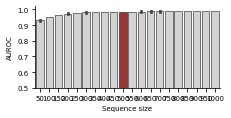

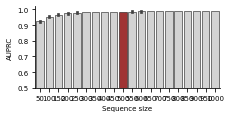

In [13]:
visualize_parameter_effects('saccharomyces_cerevisiae', scer_seqgrid, base_model, 
                            'sequence_size', 500, replicates = 10, xlab_type = int,
                            auc_ylim = (0.5,1.02), show_data = False)

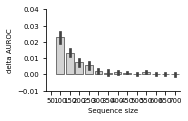

Classification AUROC:
                   mean       std       min       max
sequence_size                                        
50                  NaN       NaN       NaN       NaN
100            0.022807  0.005931  0.010606  0.028685
150            0.013339  0.003697  0.008395  0.020923
200            0.007622  0.003687  0.000170  0.014026
250            0.005552  0.003722  0.002450  0.012505
300            0.002073  0.002156 -0.001489  0.006364
350            0.001117  0.002389 -0.001888  0.005295
400            0.001267  0.001531 -0.000395  0.004444
450            0.001070  0.000545 -0.000036  0.001969
500            0.000235  0.000730 -0.000980  0.001691
550            0.001286  0.001011 -0.000257  0.002964
600            0.000458  0.001105 -0.001504  0.001980
650            0.000508  0.000960 -0.001369  0.001704
700            0.000006  0.001126 -0.001639  0.002366


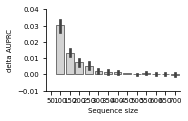

Classification AUPRC:
                   mean       std       min       max
sequence_size                                        
50                  NaN       NaN       NaN       NaN
100            0.030045  0.005977  0.018069  0.036029
150            0.013398  0.003423  0.009021  0.021239
200            0.007389  0.003739 -0.000281  0.014107
250            0.005322  0.003533  0.002066  0.011892
300            0.002088  0.002145 -0.000833  0.006046
350            0.001295  0.002260 -0.001415  0.005208
400            0.001266  0.001365 -0.000564  0.003900
450            0.001000  0.000388  0.000245  0.001580
500            0.000124  0.000630 -0.000981  0.001104
550            0.001033  0.000852 -0.000080  0.002547
600            0.000542  0.001034 -0.001588  0.001873
650            0.000555  0.001070 -0.001406  0.001942
700           -0.000109  0.001297 -0.002001  0.002375


In [14]:
visualize_parameter_deltas('saccharomyces_cerevisiae', scer_seqgrid, base_model, 
                           'sequence_size', 500, np.arange(50,750,50).tolist(),
                           'mean', replicates = 10, xlab_type = int, 
                           ylim = (-0.01,0.04), ytickint = 0.01, show_data = True)

#### Parameter grid search

In [15]:
scer_grid = pd.read_csv(os.path.join(RESOURCES, 'polyaclassifier_replicate_summary.saccharomyces_cerevisiae.txt'), sep = "\t")
scer_grid = scer_grid.loc[scer_grid['modeltype'] == 'param_imbalgrid'].copy()
print(scer_grid.shape)


(260, 21)


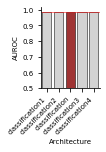


Corresponding data:
                     mean       std        se within1se
architecture                                           
classification   0.984968  0.001120  0.000354         *
classification2  0.984869  0.001078  0.000341         *
classification1  0.984456  0.001359  0.000430          
classification3  0.984334  0.000687  0.000217          
classification4  0.983771  0.000911  0.000288          

T-test for differences in AUROC:
classification1 vs classification AUROC: pval = 3.71E-01
classification2 vs classification AUROC: pval = 8.43E-01
classification3 vs classification AUROC: pval = 1.45E-01
classification4 vs classification AUROC: pval = 1.73E-02


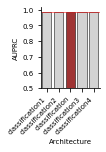


Corresponding data:
                     mean       std        se within1se
architecture                                           
classification2  0.985956  0.001257  0.000398         *
classification   0.985911  0.001004  0.000317         *
classification1  0.985479  0.001451  0.000459          
classification3  0.985194  0.000960  0.000304          
classification4  0.984854  0.001149  0.000363          

T-test for differences in AUPRC:
classification1 vs classification AUPRC: pval = 4.50E-01
classification2 vs classification AUPRC: pval = 9.29E-01
classification3 vs classification AUPRC: pval = 1.20E-01
classification4 vs classification AUPRC: pval = 4.19E-02


In [16]:
visualize_parameter_effects('saccharomyces_cerevisiae', scer_grid, base_model, 
                            'architecture', 'classification', ['classification1','classification2', 'classification', 'classification3', 'classification4'],
                            replicates = 10, rotate_labels = True, 
                            auc_line = 'mean', auc_ylim = (0.5,1.02))


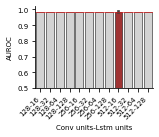


Corresponding data:
             mean       std        se within1se
label                                          
512-16   0.986807  0.000776  0.000245         *
512-64   0.986271  0.000761  0.000241          
256-16   0.986137  0.000996  0.000315          
512-128  0.986034  0.000752  0.000238          
512-32   0.985785  0.001181  0.000374          
256-32   0.985637  0.000930  0.000294          
256-128  0.985420  0.000924  0.000292          
256-64   0.985355  0.001198  0.000379          
128-32   0.984968  0.001120  0.000354          
128-64   0.984569  0.000573  0.000181          
128-16   0.984242  0.001299  0.000411          
128-128  0.984159  0.000961  0.000304          

T-test for differences in AUROC:
128-16 vs 512-16 AUROC: pval = 4.28E-05
128-32 vs 512-16 AUROC: pval = 4.62E-04
128-64 vs 512-16 AUROC: pval = 8.16E-07
128-128 vs 512-16 AUROC: pval = 2.37E-06
256-16 vs 512-16 AUROC: pval = 1.11E-01
256-32 vs 512-16 AUROC: pval = 6.83E-03
256-64 vs 512-16 AUROC: pval = 4

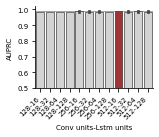


Corresponding data:
             mean       std        se within1se
label                                          
512-16   0.987648  0.000752  0.000238         *
512-64   0.987167  0.000862  0.000273          
256-16   0.987117  0.000971  0.000307          
512-128  0.986968  0.000839  0.000265          
512-32   0.986696  0.001403  0.000444          
256-32   0.986542  0.001147  0.000363          
256-128  0.986432  0.001017  0.000322          
256-64   0.986428  0.001225  0.000387          
128-32   0.985911  0.001004  0.000317          
128-64   0.985537  0.000723  0.000229          
128-128  0.985261  0.001037  0.000328          
128-16   0.985239  0.001067  0.000337          

T-test for differences in AUPRC:
128-16 vs 512-16 AUPRC: pval = 1.58E-05
128-32 vs 512-16 AUPRC: pval = 3.62E-04
128-64 vs 512-16 AUPRC: pval = 5.05E-06
128-128 vs 512-16 AUPRC: pval = 1.41E-05
256-16 vs 512-16 AUPRC: pval = 1.89E-01
256-32 vs 512-16 AUPRC: pval = 2.02E-02
256-64 vs 512-16 AUPRC: pval = 1

In [17]:
visualize_combination_effects('saccharomyces_cerevisiae', scer_grid, base_model, 
                              ['conv_units','lstm_units'], '512-16', xlab_types = [int,int], 
                              replicates = 10, rotate_labels = True, 
                              auc_line = 'mean', auc_ylim = (0.5,1.02))


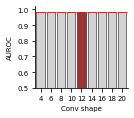


Corresponding data:
                mean       std        se within1se
conv_shape                                        
12          0.985246  0.000600  0.000190         *
8           0.984968  0.001120  0.000354          
10          0.984932  0.000960  0.000303          
14          0.984717  0.001082  0.000342          
6           0.984597  0.000979  0.000310          
20          0.984128  0.001310  0.000414          
16          0.984125  0.001749  0.000553          
18          0.983799  0.001233  0.000390          
4           0.982188  0.000893  0.000283          

T-test for differences in AUROC:
   4 vs   12 AUROC: pval = 4.51E-08
   6 vs   12 AUROC: pval = 9.11E-02
   8 vs   12 AUROC: pval = 4.98E-01
  10 vs   12 AUROC: pval = 3.92E-01
  14 vs   12 AUROC: pval = 1.93E-01
  16 vs   12 AUROC: pval = 7.14E-02
  18 vs   12 AUROC: pval = 3.67E-03
  20 vs   12 AUROC: pval = 2.45E-02


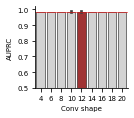


Corresponding data:
                mean       std        se within1se
conv_shape                                        
12          0.986226  0.000677  0.000214         *
10          0.986079  0.001037  0.000328         *
8           0.985911  0.001004  0.000317          
6           0.985695  0.001047  0.000331          
14          0.985490  0.001257  0.000397          
16          0.985110  0.001603  0.000507          
18          0.984855  0.001315  0.000416          
20          0.984849  0.001279  0.000404          
4           0.983179  0.000922  0.000292          

T-test for differences in AUPRC:
   4 vs   12 AUPRC: pval = 1.18E-07
   6 vs   12 AUPRC: pval = 1.95E-01
   8 vs   12 AUPRC: pval = 4.21E-01
  10 vs   12 AUPRC: pval = 7.12E-01
  14 vs   12 AUPRC: pval = 1.21E-01
  16 vs   12 AUPRC: pval = 5.77E-02
  18 vs   12 AUPRC: pval = 8.93E-03
  20 vs   12 AUPRC: pval = 7.55E-03


In [18]:
visualize_parameter_effects('saccharomyces_cerevisiae', scer_grid, base_model, 
                            'conv_shape', 12, replicates = 10, xlab_type=int,
                            auc_line = 'mean', auc_ylim = (0.5,1.02))


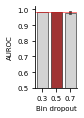


Corresponding data:
                 mean       std        se within1se
bin_dropout                                        
0.5          0.984968  0.001120  0.000354         *
0.3          0.981570  0.000884  0.000280          
0.7          0.979417  0.002028  0.000641          

T-test for differences in AUROC:
 0.3 vs  0.5 AUROC: pval = 5.74E-07
 0.7 vs  0.5 AUROC: pval = 5.27E-07


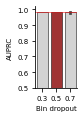


Corresponding data:
                 mean       std        se within1se
bin_dropout                                        
0.5          0.985911  0.001004  0.000317         *
0.3          0.982804  0.001098  0.000347          
0.7          0.980790  0.001970  0.000623          

T-test for differences in AUPRC:
 0.3 vs  0.5 AUPRC: pval = 3.36E-06
 0.7 vs  0.5 AUPRC: pval = 8.42E-07


In [19]:
visualize_parameter_effects('saccharomyces_cerevisiae', scer_grid, base_model, 
                            'bin_dropout', 0.5, replicates = 10,
                            auc_line = 'mean', auc_ylim = (0.5,1.02))


### S. pombe

In [20]:
spom_seqgrid = pd.read_csv(os.path.join(RESOURCES, 'polyaclassifier_replicate_summary.schizosaccharomyces_pombe.txt'), sep = "\t")
spom_seqgrid = spom_seqgrid.loc[spom_seqgrid['modeltype'] == 'sequence_imbalgrid'].copy()
print(spom_seqgrid.shape)


(200, 21)


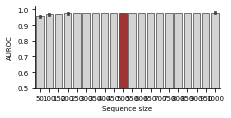

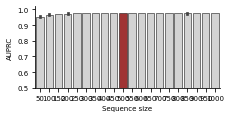

In [21]:
visualize_parameter_effects('schizosaccharomyces_pombe', spom_seqgrid, base_model, 
                            'sequence_size', 500, replicates = 10, xlab_type = int,
                            auc_ylim = (0.5,1.02), show_data = False)

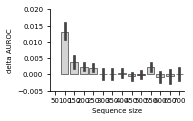

Classification AUROC:
                   mean       std       min       max
sequence_size                                        
50                  NaN       NaN       NaN       NaN
100            0.013068  0.004213  0.007603  0.023035
150            0.003754  0.002897 -0.000904  0.009944
200            0.002300  0.001882 -0.000685  0.005640
250            0.002133  0.001700 -0.000212  0.005328
300            0.000297  0.002424 -0.005091  0.003435
350            0.000144  0.002586 -0.005673  0.004340
400            0.000375  0.002161 -0.003738  0.004593
450           -0.000556  0.001942 -0.003920  0.002963
500           -0.000072  0.001816 -0.003874  0.002350
550            0.002219  0.002027 -0.000013  0.005451
600           -0.000659  0.002717 -0.006608  0.003130
650           -0.000497  0.003412 -0.006155  0.003814
700            0.000212  0.003383 -0.003971  0.007076


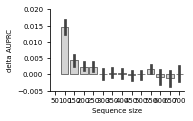

Classification AUPRC:
                   mean       std       min       max
sequence_size                                        
50                  NaN       NaN       NaN       NaN
100            0.014495  0.004093  0.008881  0.023375
150            0.004329  0.002913 -0.000561  0.009885
200            0.002437  0.001870  0.000536  0.006519
250            0.002435  0.002121 -0.000624  0.007265
300            0.000133  0.002732 -0.005813  0.002988
350            0.000461  0.002354 -0.004443  0.004237
400            0.000389  0.002476 -0.003570  0.004903
450           -0.000296  0.002112 -0.003552  0.002728
500            0.000061  0.002061 -0.003866  0.002133
550            0.001719  0.002338 -0.001938  0.004895
600           -0.000663  0.003557 -0.008221  0.004090
650           -0.001112  0.004166 -0.008576  0.004168
700            0.000271  0.003760 -0.004565  0.007395


In [22]:
visualize_parameter_deltas('schizosaccharomyces_pombe', spom_seqgrid, base_model, 
                           'sequence_size', 500, np.arange(50,750,50).tolist(),
                           'mean', replicates = 10, xlab_type = int, 
                           ylim = (-0.005,0.02), ytickint = 0.005, show_data = True)

#### Parameter grid search

In [23]:
spom_grid = pd.read_csv(os.path.join(RESOURCES, 'polyaclassifier_replicate_summary.schizosaccharomyces_pombe.txt'), sep = "\t")
spom_grid = spom_grid.loc[spom_grid['modeltype'] == 'param_imbalgrid'].copy()
print(spom_grid.shape)


(260, 21)


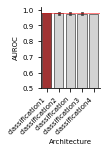


Corresponding data:
                     mean       std        se within1se
architecture                                           
classification1  0.978104  0.001644  0.000520         *
classification2  0.976762  0.002280  0.000721          
classification   0.976275  0.002857  0.000903          
classification3  0.976105  0.002474  0.000782          
classification4  0.975214  0.001798  0.000568          

T-test for differences in AUROC:
classification2 vs classification1 AUROC: pval = 1.48E-01
classification vs classification1 AUROC: pval = 9.62E-02
classification3 vs classification1 AUROC: pval = 4.74E-02
classification4 vs classification1 AUROC: pval = 1.46E-03


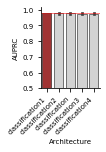


Corresponding data:
                     mean       std        se within1se
architecture                                           
classification1  0.978054  0.002433  0.000769         *
classification2  0.977065  0.002651  0.000838          
classification   0.976497  0.003479  0.001100          
classification3  0.976385  0.002797  0.000884          
classification4  0.975480  0.002184  0.000691          

T-test for differences in AUPRC:
classification2 vs classification1 AUPRC: pval = 3.96E-01
classification vs classification1 AUPRC: pval = 2.61E-01
classification3 vs classification1 AUPRC: pval = 1.71E-01
classification4 vs classification1 AUPRC: pval = 2.28E-02


In [24]:
visualize_parameter_effects('schizosaccharomyces_pombe', spom_grid, base_model, 
                            'architecture', 'classification1', ['classification1','classification2', 'classification', 'classification3', 'classification4'],
                            replicates = 10, rotate_labels = True, 
                            auc_line = 'mean', auc_ylim = (0.5,1.02))

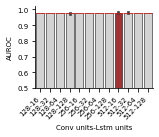


Corresponding data:
             mean       std        se within1se
label                                          
512-16   0.980108  0.001588  0.000502         *
512-32   0.980107  0.001275  0.000403         *
256-16   0.979083  0.002016  0.000638          
256-64   0.978515  0.002202  0.000696          
256-32   0.978277  0.001561  0.000494          
512-64   0.977471  0.002434  0.000770          
256-128  0.977239  0.003167  0.001001          
512-128  0.976851  0.002561  0.000810          
128-64   0.976642  0.002154  0.000681          
128-32   0.976275  0.002857  0.000903          
128-128  0.976201  0.003692  0.001167          
128-16   0.976101  0.002489  0.000787          

T-test for differences in AUROC:
128-16 vs 512-16 AUROC: pval = 4.40E-04
128-32 vs 512-16 AUROC: pval = 1.61E-03
128-64 vs 512-16 AUROC: pval = 6.80E-04
128-128 vs 512-16 AUROC: pval = 6.54E-03
256-16 vs 512-16 AUROC: pval = 2.23E-01
256-32 vs 512-16 AUROC: pval = 1.82E-02
256-64 vs 512-16 AUROC: pval = 8

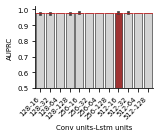


Corresponding data:
             mean       std        se within1se
label                                          
512-16   0.980633  0.001773  0.000561         *
512-32   0.980425  0.001739  0.000550         *
256-16   0.979518  0.002692  0.000851          
256-64   0.978880  0.002698  0.000853          
256-32   0.978584  0.002193  0.000694          
256-128  0.977988  0.003522  0.001114          
512-64   0.977962  0.002804  0.000887          
512-128  0.977325  0.003093  0.000978          
128-64   0.976797  0.002434  0.000770          
128-32   0.976497  0.003479  0.001100          
128-128  0.976257  0.004417  0.001397          
128-16   0.976159  0.003161  0.001000          

T-test for differences in AUPRC:
128-16 vs 512-16 AUPRC: pval = 1.04E-03
128-32 vs 512-16 AUPRC: pval = 3.57E-03
128-64 vs 512-16 AUPRC: pval = 7.89E-04
128-128 vs 512-16 AUPRC: pval = 9.40E-03
256-16 vs 512-16 AUPRC: pval = 2.89E-01
256-32 vs 512-16 AUPRC: pval = 3.38E-02
256-64 vs 512-16 AUPRC: pval = 1

In [25]:
visualize_combination_effects('schizosaccharomyces_pombe', spom_grid, base_model, 
                              ['conv_units','lstm_units'], '512-16', xlab_types = [int,int], 
                              replicates = 10, rotate_labels = True, 
                              auc_line = 'mean', auc_ylim = (0.5,1.02))

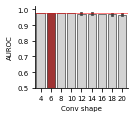


Corresponding data:
                mean       std        se within1se
conv_shape                                        
6           0.977535  0.001761  0.000557         *
4           0.976634  0.001699  0.000537          
10          0.976435  0.001944  0.000615          
8           0.976275  0.002857  0.000903          
14          0.973786  0.002877  0.000910          
12          0.973690  0.003286  0.001039          
16          0.970875  0.003551  0.001123          
18          0.968653  0.002548  0.000806          
20          0.967405  0.005177  0.001637          

T-test for differences in AUROC:
   4 vs    6 AUROC: pval = 2.59E-01
   8 vs    6 AUROC: pval = 2.50E-01
  10 vs    6 AUROC: pval = 2.01E-01
  12 vs    6 AUROC: pval = 4.34E-03
  14 vs    6 AUROC: pval = 2.47E-03
  16 vs    6 AUROC: pval = 4.73E-05
  18 vs    6 AUROC: pval = 3.93E-08
  20 vs    6 AUROC: pval = 1.51E-05


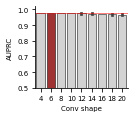


Corresponding data:
                mean       std        se within1se
conv_shape                                        
6           0.977894  0.002176  0.000688         *
10          0.977045  0.002077  0.000657          
4           0.976846  0.002015  0.000637          
8           0.976497  0.003479  0.001100          
12          0.973995  0.003605  0.001140          
14          0.973710  0.003421  0.001082          
16          0.970926  0.003332  0.001054          
18          0.968864  0.002613  0.000826          
20          0.967244  0.005736  0.001814          

T-test for differences in AUPRC:
   4 vs    6 AUPRC: pval = 2.78E-01
   8 vs    6 AUPRC: pval = 2.96E-01
  10 vs    6 AUPRC: pval = 3.84E-01
  12 vs    6 AUPRC: pval = 8.98E-03
  14 vs    6 AUPRC: pval = 4.32E-03
  16 vs    6 AUPRC: pval = 2.95E-05
  18 vs    6 AUPRC: pval = 1.22E-07
  20 vs    6 AUPRC: pval = 3.26E-05


In [26]:
visualize_parameter_effects('schizosaccharomyces_pombe', spom_grid, base_model, 
                            'conv_shape', 6, replicates = 10, xlab_type = int,
                            auc_line = 'mean', auc_ylim = (0.5,1.02))

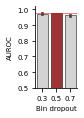


Corresponding data:
                 mean       std        se within1se
bin_dropout                                        
0.5          0.976275  0.002857  0.000903         *
0.3          0.973285  0.001358  0.000429          
0.7          0.961661  0.008993  0.002844          

T-test for differences in AUROC:
 0.3 vs  0.5 AUROC: pval = 7.87E-03
 0.7 vs  0.5 AUROC: pval = 1.16E-04


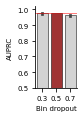


Corresponding data:
                 mean       std        se within1se
bin_dropout                                        
0.5          0.976497  0.003479  0.001100         *
0.3          0.974007  0.002105  0.000666          
0.7          0.961265  0.008762  0.002771          

T-test for differences in AUPRC:
 0.3 vs  0.5 AUPRC: pval = 6.87E-02
 0.7 vs  0.5 AUPRC: pval = 7.34E-05


In [27]:
visualize_parameter_effects('schizosaccharomyces_pombe', spom_grid, base_model, 
                            'bin_dropout', 0.5, replicates = 10,
                            auc_line = 'mean', auc_ylim = (0.5,1.02))

### A. thaliana

In [28]:
atha_seqgrid = pd.read_csv(os.path.join(RESOURCES, 'polyaclassifier_replicate_summary.arabidopsis_thaliana.txt'), sep = "\t")
atha_seqgrid = atha_seqgrid.loc[atha_seqgrid['modeltype'] == 'sequence_imbalgrid'].copy()
print(atha_seqgrid.shape)


(200, 21)


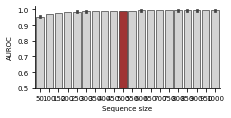

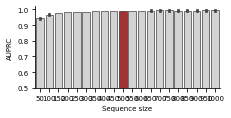

In [29]:
visualize_parameter_effects('arabidopsis_thaliana', atha_seqgrid, base_model, 
                            'sequence_size', 500, replicates = 10, xlab_type = int,
                            auc_ylim = (0.5,1.02), show_data = False)

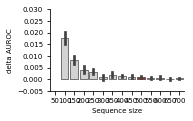

Classification AUROC:
                   mean       std       min       max
sequence_size                                        
50                  NaN       NaN       NaN       NaN
100            0.017455  0.004465  0.012100  0.028119
150            0.008116  0.003159  0.002874  0.014167
200            0.003919  0.002752  0.000781  0.010733
250            0.003221  0.001881  0.000993  0.007030
300            0.000863  0.001819 -0.001691  0.004190
350            0.001884  0.001635  0.000040  0.004972
400            0.001286  0.000758 -0.000442  0.002574
450            0.000999  0.001199 -0.001280  0.002662
500            0.000977  0.000941 -0.000581  0.002519
550            0.000533  0.000778 -0.000687  0.001814
600            0.000625  0.000945 -0.000876  0.002032
650            0.000216  0.000719 -0.000771  0.001149
700            0.000377  0.000583 -0.000676  0.001132


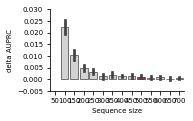

Classification AUPRC:
                   mean       std       min       max
sequence_size                                        
50                  NaN       NaN       NaN       NaN
100            0.022289  0.005334  0.014795  0.034535
150            0.010340  0.003589  0.005060  0.017069
200            0.004669  0.002705  0.001360  0.011276
250            0.003274  0.001909  0.001097  0.007608
300            0.001180  0.001881 -0.001343  0.004784
350            0.001820  0.001771 -0.000392  0.005121
400            0.001331  0.000737 -0.000374  0.002271
450            0.001268  0.001361 -0.001278  0.002745
500            0.001003  0.001015 -0.000682  0.002852
550            0.000625  0.001071 -0.001312  0.002397
600            0.000731  0.001125 -0.000969  0.002168
650            0.000279  0.000950 -0.001107  0.001384
700            0.000369  0.000772 -0.001228  0.001080


In [30]:
visualize_parameter_deltas('arabidopsis_thaliana', atha_seqgrid, base_model, 
                           'sequence_size', 500, np.arange(50,750,50).tolist(),
                           'mean', replicates = 10, xlab_type = int, 
                           ylim = (-0.005,0.03), ytickint = 0.005, show_data = True)

#### Parameter grid search

In [31]:
atha_grid = pd.read_csv(os.path.join(RESOURCES, 'polyaclassifier_replicate_summary.arabidopsis_thaliana.txt'), sep = "\t")
atha_grid = atha_grid.loc[atha_grid['modeltype'] == 'param_imbalgrid'].copy()
print(atha_grid.shape)


(260, 21)


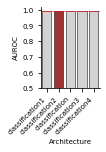


Corresponding data:
                     mean       std        se within1se
architecture                                           
classification2  0.992166  0.000683  0.000216         *
classification   0.991748  0.000696  0.000220          
classification1  0.991606  0.001094  0.000346          
classification3  0.991197  0.000848  0.000268          
classification4  0.991054  0.000733  0.000232          

T-test for differences in AUROC:
classification1 vs classification2 AUROC: pval = 1.86E-01
classification vs classification2 AUROC: pval = 1.92E-01
classification3 vs classification2 AUROC: pval = 1.15E-02
classification4 vs classification2 AUROC: pval = 2.50E-03


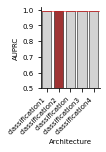


Corresponding data:
                     mean       std        se within1se
architecture                                           
classification2  0.991385  0.000794  0.000251         *
classification   0.990908  0.001006  0.000318          
classification1  0.990709  0.001078  0.000341          
classification3  0.990128  0.001154  0.000365          
classification4  0.990098  0.000824  0.000261          

T-test for differences in AUPRC:
classification1 vs classification2 AUPRC: pval = 1.28E-01
classification vs classification2 AUPRC: pval = 2.55E-01
classification3 vs classification2 AUPRC: pval = 1.09E-02
classification4 vs classification2 AUPRC: pval = 2.26E-03


In [32]:
visualize_parameter_effects('arabidopsis_thaliana', atha_grid, base_model, 
                            'architecture', 'classification2', ['classification1','classification2', 'classification', 'classification3', 'classification4'],
                            replicates = 10, rotate_labels = True, 
                            auc_line = 'mean', auc_ylim = (0.5,1.02))

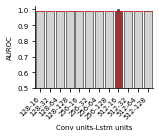


Corresponding data:
             mean       std        se within1se
label                                          
512-16   0.993152  0.000951  0.000301         *
512-32   0.992970  0.000855  0.000270         *
512-64   0.992965  0.000522  0.000165         *
512-128  0.992953  0.000760  0.000240         *
256-64   0.992668  0.000754  0.000238          
256-16   0.992460  0.000617  0.000195          
256-32   0.992381  0.000973  0.000308          
256-128  0.992336  0.000894  0.000283          
128-64   0.992077  0.000822  0.000260          
128-128  0.992052  0.000699  0.000221          
128-16   0.991854  0.000450  0.000142          
128-32   0.991748  0.000696  0.000220          

T-test for differences in AUROC:
128-16 vs 512-16 AUROC: pval = 1.05E-03
128-32 vs 512-16 AUROC: pval = 1.41E-03
128-64 vs 512-16 AUROC: pval = 1.45E-02
128-128 vs 512-16 AUROC: pval = 8.63E-03
256-16 vs 512-16 AUROC: pval = 6.94E-02
256-32 vs 512-16 AUROC: pval = 8.98E-02
256-64 vs 512-16 AUROC: pval = 2

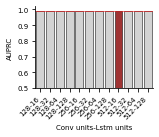


Corresponding data:
             mean       std        se within1se
label                                          
512-16   0.992483  0.001105  0.000349         *
512-32   0.992244  0.000816  0.000258         *
512-64   0.992189  0.000757  0.000239         *
512-128  0.992083  0.000958  0.000303          
256-64   0.991869  0.000938  0.000297          
256-16   0.991631  0.000680  0.000215          
256-32   0.991576  0.001074  0.000340          
256-128  0.991545  0.000965  0.000305          
128-64   0.991341  0.000978  0.000309          
128-128  0.991204  0.000991  0.000313          
128-16   0.991127  0.000492  0.000155          
128-32   0.990908  0.001006  0.000318          

T-test for differences in AUPRC:
128-16 vs 512-16 AUPRC: pval = 2.31E-03
128-32 vs 512-16 AUPRC: pval = 3.70E-03
128-64 vs 512-16 AUPRC: pval = 2.48E-02
128-128 vs 512-16 AUPRC: pval = 1.39E-02
256-16 vs 512-16 AUPRC: pval = 5.24E-02
256-32 vs 512-16 AUPRC: pval = 7.92E-02
256-64 vs 512-16 AUPRC: pval = 1

In [33]:
visualize_combination_effects('arabidopsis_thaliana', atha_grid, base_model, 
                              ['conv_units','lstm_units'], '512-16', xlab_types = [int,int], 
                              replicates = 10, rotate_labels = True, 
                              auc_line = 'mean', auc_ylim = (0.5,1.02))

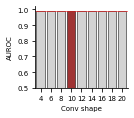


Corresponding data:
                mean       std        se within1se
conv_shape                                        
10          0.991844  0.000761  0.000241         *
6           0.991769  0.000510  0.000161         *
8           0.991748  0.000696  0.000220         *
14          0.991525  0.000747  0.000236          
12          0.991514  0.000651  0.000206          
4           0.991128  0.000833  0.000264          
18          0.991058  0.000772  0.000244          
16          0.990896  0.000735  0.000232          
20          0.990593  0.000592  0.000187          

T-test for differences in AUROC:
   4 vs   10 AUROC: pval = 6.00E-02
   6 vs   10 AUROC: pval = 7.97E-01
   8 vs   10 AUROC: pval = 7.71E-01
  12 vs   10 AUROC: pval = 3.11E-01
  14 vs   10 AUROC: pval = 3.56E-01
  16 vs   10 AUROC: pval = 1.10E-02
  18 vs   10 AUROC: pval = 3.41E-02
  20 vs   10 AUROC: pval = 6.64E-04


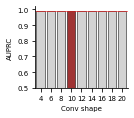


Corresponding data:
                mean       std        se within1se
conv_shape                                        
10          0.990935  0.000961  0.000304         *
8           0.990908  0.001006  0.000318         *
6           0.990854  0.000837  0.000265         *
14          0.990823  0.000901  0.000285         *
12          0.990720  0.000718  0.000227         *
18          0.990397  0.000830  0.000262          
4           0.990268  0.000925  0.000293          
16          0.990075  0.000888  0.000281          
20          0.989808  0.000779  0.000246          

T-test for differences in AUPRC:
   4 vs   10 AUPRC: pval = 1.31E-01
   6 vs   10 AUPRC: pval = 8.42E-01
   8 vs   10 AUPRC: pval = 9.52E-01
  12 vs   10 AUPRC: pval = 5.77E-01
  14 vs   10 AUPRC: pval = 7.91E-01
  16 vs   10 AUPRC: pval = 5.22E-02
  18 vs   10 AUPRC: pval = 1.96E-01
  20 vs   10 AUPRC: pval = 9.92E-03


In [34]:
visualize_parameter_effects('arabidopsis_thaliana', atha_grid, base_model, 
                            'conv_shape', 10, replicates = 10, xlab_type = int,
                            auc_line = 'mean', auc_ylim = (0.5,1.02))

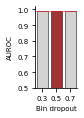


Corresponding data:
                 mean       std        se within1se
bin_dropout                                        
0.5          0.991748  0.000696  0.000220         *
0.3          0.990249  0.001618  0.000512          
0.7          0.989308  0.002112  0.000668          

T-test for differences in AUROC:
 0.3 vs  0.5 AUROC: pval = 1.50E-02
 0.7 vs  0.5 AUROC: pval = 2.74E-03


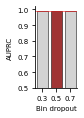


Corresponding data:
                 mean       std        se within1se
bin_dropout                                        
0.5          0.990908  0.001006  0.000318         *
0.3          0.989345  0.001625  0.000514          
0.7          0.988406  0.002382  0.000753          

T-test for differences in AUPRC:
 0.3 vs  0.5 AUPRC: pval = 1.86E-02
 0.7 vs  0.5 AUPRC: pval = 6.73E-03


In [35]:
visualize_parameter_effects('arabidopsis_thaliana', atha_grid, base_model, 
                            'bin_dropout', 0.5, replicates = 10,
                            auc_line = 'mean', auc_ylim = (0.5,1.02))